In [1]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import pandas as pd
import os
import numpy as np
import datetime
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import kpss

In [2]:
top_down_path = os.getcwd()
os.chdir("../Data")
data_path = os.getcwd()
os.chdir(top_down_path)

# Read data

In [3]:
# Read preprocessed
df = pd.read_csv(os.path.join(data_path, "preprocessed.csv"), index_col=0)
df.index = pd.to_datetime(df.index)

In [4]:
df[['rlm', 'slp']].mean() * 365 #/ df[['slp', 'rlm']].sum().sum()

rlm    586.975086
slp    408.364157
dtype: float64

In [5]:
df.head().transpose()

,2017-01-01,2017-01-02,2017-01-03,2017-01-04,2017-01-05
slp,2.30229,2.36278,2.28435,2.20389,2.50925
rlm,1.67344,2.05604,2.0301,2.10876,2.358
industry,1.43044,1.64585,1.69169,1.76154,1.78844
gas_to_electricity,0.325731,0.549828,0.453608,0.465417,0.763463
electricity_from_gas,0.139161,0.234902,0.193794,0.198839,0.326173
gas_price [€/MWh],NaN,NaN,NaN,NaN,NaN
producing_sector,91.1,91.1,91.1,91.1,91.1
manufacturing_sector,94.1,94.1,94.1,94.1,94.1
hospitality_sector,82.6,82.6,82.6,82.6,82.6
retail_sector,96.1,96.1,96.1,96.1,96.1


# Prepare regression data

In [6]:
dfx = df.copy()
dfx = dfx.rename(columns={
    'aggregated': 'w2h',
    'electricity_from_gas': 'power',
    'producing_sector': 'prod',
    'manufacturing_sector': 'manu',
    'retail_sector': 'retail',
    'hospitality_sector': 'hosp',
    'gas_price [€/MWh]': 'prices',
    'temperature': 'temp',
    'temperature_inertia': 'temp_inertia'
})

dfx['log_slp'] = np.log(dfx['slp'])
dfx['log_rlm'] = np.log(dfx['rlm'])
dfx['log_industry'] = np.log(dfx['industry'])
dfx['power2'] = dfx['power'].apply(lambda x: x**2)

dfx = dfx[
    (dfx.holiday==0) & 
    (dfx.christmas_period==0) & 
    (dfx.bridgeday==0)
]

# Cut December 22-23
dfx = dfx[((dfx.index.month!=12)|(dfx.index.day<22))]

# Cut corona
# covid_beginning = "2020-02-01" --> lockdown started on 13 March 2020
#dfx = dfx[(dfx.index < '2020-03-01')|(dfx.index >= '2021-05-01')]
# invasion_date = "2022-02-24"

In [7]:
def model(dependent_variable, control_list):
    
    m = f'{dependent_variable} ~ 1 + time + C(month) + C(weekday) + ' + ' + '.join(control_list)
    print(m)
    return smf.ols(m, dfx.loc[fitting_start:]).fit(cov_type='HAC', cov_kwds={'maxlags':6})

In [8]:
def all_models(dummy_list, consumer='rlm', further_controls=False, econ=False):
    
    results = {}
    
    names = ['naive', 'temp',]
    if econ:
        names += ['temp+econ']
    if consumer=='rlm':
        names += ['temp+econ']
    if consumer =="power":
        names = ['naive']
    
    for name in names:
    
        control_list = [d for d in dummy_list]        
        if 'temp' in name:
            control_list += ['residential','commercial','time*residential','solar']
#        if 'temp' in name:
#            control_list += 'w2h','time*w2h','temp,'solar']
        if 'econ' in name:
            control_list += ['manu','prod'] if (consumer=='rlm' or consumer=='industry') else ['hosp','retail']
        if 'naive' in name:
            #control_list += ['temp','time*temp','solar','time*solar', "temp_inertia"]
            #control_list += ['temp_inertia']
            control_list = control_list
        results[name] = model(f'{"log_" if log else ""}{consumer}', control_list)

    return results

In [9]:
def extract_results(dummy_list, results):
    
    extracted_results = pd.concat(
        [results.params, results.bse], keys=['coef', 'se'], axis=1
    )
    
    extracted_results = extracted_results*100 if log else extracted_results
    extracted_results = extracted_results.loc[[d + '[T.True]' for d in dummy_list]]
    extracted_results.index = dummy_list
    extracted_results['low'] = extracted_results['coef'] - 2 * extracted_results['se']
    extracted_results['high'] = extracted_results['coef'] + 2 * extracted_results['se']
    
    return extracted_results

# One crisis dummy

In [10]:
title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',  
        'power':'power'  
}

In [11]:
def plot_waterfall(ax, results, consumer='rlm', ylabel=''):

    colors = ['tab:blue', 'tab:orange', 'tab:purple', 'tab:green', 'tab:red']
    
    for i, (name, res) in enumerate(results.items()):
        
        # first bar
        if i==0:
            ax.bar(i, res['coef'], alpha=0.5, color=colors[i])
            ax.plot([i,i], [res['low'], res['high']], color=colors[i])
        
        # waterfall
        if i > 0:
            ax.bar(i, res['coef'] - previous_coef, bottom=previous_coef, alpha=0.5, color=colors[i])    
            ax.plot([i-1.4,i+0.4], [previous_coef, previous_coef], color='black', linewidth=0.7, linestyle='--')
            ax.plot([i-0.4,i+1.4], [res['coef'], res['coef']], color='black', linewidth=0.7, linestyle='--')
            
        previous_coef = res['coef']
    
    # last bar
    if consumer != "power":
        i += 1
        ax.bar(i, res['coef'], alpha=0.5, color=colors[-1])
        ax.plot([i,i], [res['low'], res['high']], color=colors[-1])

    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_title(title_conversion[consumer])    
    if log:
        ax.set_ylim(-21, 7)
        
    labels = ['Overall\nchange', 'Temperature']
    if 'temp+econ' in results.keys():
        labels += ['Economic\nactivity']
    if consumer=='rlm': 
        labels += ['Power\nsector']
    if consumer=='power': 
        labels = ['Overall\nchange']
    ax.set_xticks(range(len(results)) if consumer == "power" else range(len(results)+1))
    ax.set_xticklabels(labels if consumer == "power" else (labels + ['Crisis\nresponse']))

In [12]:
def one_dummy(further_controls=False, econ=False):
    
    dummy_list=['crisis']
    dfx['crisis'] = dfx.index.map(lambda x: x >= crisis_start)

    results = {
        consumer: all_models(dummy_list, consumer, further_controls=further_controls, econ=econ) 
        for consumer in ['slp', 'industry', 'power']
    }
    
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14,4.5), sharey='row', gridspec_kw={'width_ratios': [1,1.3, 0.3]})

    res = {m: extract_results(dummy_list, value) for m, value in results['slp'].items()}
    ax1 = plot_waterfall(ax1, res, 'slp', 'Estimated change in demand ' + ('(%)' if log else '(TWh/d)'))

    res = {m: extract_results(dummy_list, value) for m, value in results['industry'].items()}
    ax2 = plot_waterfall(ax2, res, 'industry')
    
    res = {m: extract_results(dummy_list, value) for m, value in results['power'].items()}
    ax3 = plot_waterfall(ax3, res, 'power')

    plt.tight_layout()
    
    return results

## Main Specification

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


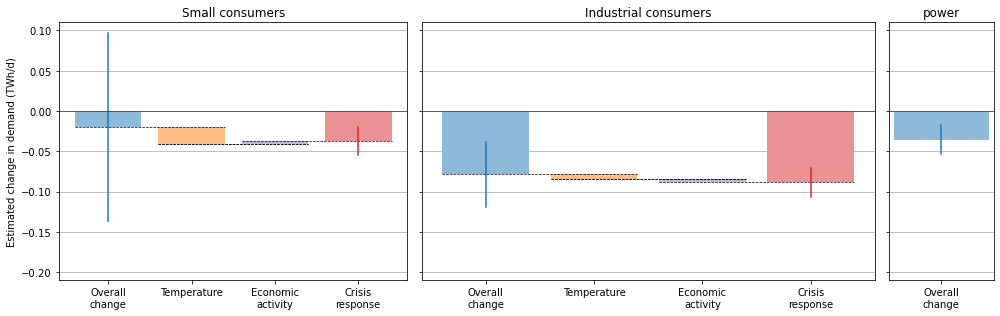

In [13]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=True)
plt.ylim(-.21, .11)
plt.savefig(f'one_dummy.png', dpi=300)

In [14]:
#results['industry']['temp+econ'].summary()
#results['slp']['temp+econ'].summary()
results['power']['naive'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.479
Model:                            OLS   Adj. R-squared:                  0.473
Method:                 Least Squares   F-statistic:                     79.86
Date:                Fri, 15 Jul 2022   Prob (F-statistic):          1.85e-221
Time:                        13:53:07   Log-Likelihood:                 2529.2
No. Observations:                1788   AIC:                            -5018.
Df Residuals:                    1768   BIC:                            -4909.
Df Model:                          19                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2748      0.012     22.305      0.000       0.251       0.299
C(month)[T.2]              -0.0195      0.014     -1.441      0.150      -0.046       0.007
C(month)[T.3]              -0.0469      0.013     -3.607      0.000      -0.072      -0.021
C(month)[T.4]              -0.0801      0.013     -6.006      0.000      -0.106      -0.054
C(month)[T.5]              -0.1066      0.012     -9.049      0.000      -0.130      -0.084
C(month)[T.6]              -0.0981      0.012     -8.050      0.000      -0.122      -0.074
C(month)[T.7]              -0.0884      0.013     -6.908      0.000      -0.113      -0.063
C(month)[T.8]              -0.0949      0.013     -7.554      0.000      -0.120      -0.070
C(month)[T.9]              -0.0835      0.014     -6.186      0.000      -0.110      -0.057
C(month)[T.10]             -0.0689      0.013     -5.327      0.000      -0.094      -0.044
C(month)[T.11]             -0.0108      0.014     -0.799      0.424      -0.037       0.016
C(month)[T.12]              0.0045      0.017      0.269      0.788      -0.028       0.037
C(weekday)[T.Monday]       -0.0009      0.005     -0.186      0.853      -0.010       0.008
C(weekday)[T.Saturday]     -0.0677      0.003    -19.703      0.000      -0.074      -0.061
C(weekday)[T.Sunday]       -0.0916      0.004    -22.515      0.000      -0.100      -0.084
C(weekday)[T.Thursday]      0.0127      0.004      3.437      0.001       0.005       0.020
C(weekday)[T.Tuesday]       0.0151      0.005      3.106      0.002       0.006       0.025
C(weekday)[T.Wednesday]     0.0111      0.005      2.410      0.016       0.002       0.020
crisis[T.True]             -0.0357      0.009     -3.928      0.000      -0.054      -0.018
time                     2.115e-05   5.82e-06      3.635      0.000    9.74e-06    3.25e-05
==============================================================================
Omnibus:                        2.809   Durbin-Watson:                   0.694
Prob(Omnibus):                  0.245   Jarque-Bera (JB):                2.868
Skew:                           0.088   Prob(JB):                        0.238
Kurtosis:                       2.913   Cond. No.                     1.34e+04
==============================================================================

Notes:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 6 lags and without small sample correction
[2] The condition number is large, 1.34e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [15]:
# year-on-year
for consumer  in ["industry", "slp" ]:
    
    crisis_coefficient = -results[consumer]['temp+econ'].params["crisis[T.True]"]
    ref = dfx[(dfx.index >= '2020-08-01') & (dfx.index < '2021-05-01')][consumer].mean()  #, (338+58)/(338+141+58))
    print(
          title_conversion[consumer] + ": " + str(crisis_coefficient) + " TWh/d " + "\n" +"which is " + str(round(100*crisis_coefficient/ ref)) +" % of "+ str(ref) + " TWh/d avg. demand during months 8-3 before crisis"+ "\n" 
         )

Industrial consumers: 0.08870417604438516 TWh/d 
which is 7 % of 1.3602886566703245 TWh/d avg. demand during months 8-3 before crisis

Small consumers: 0.03732487344610588 TWh/d 
which is 3 % of 1.3860316869344256 TWh/d avg. demand during months 8-3 before crisis



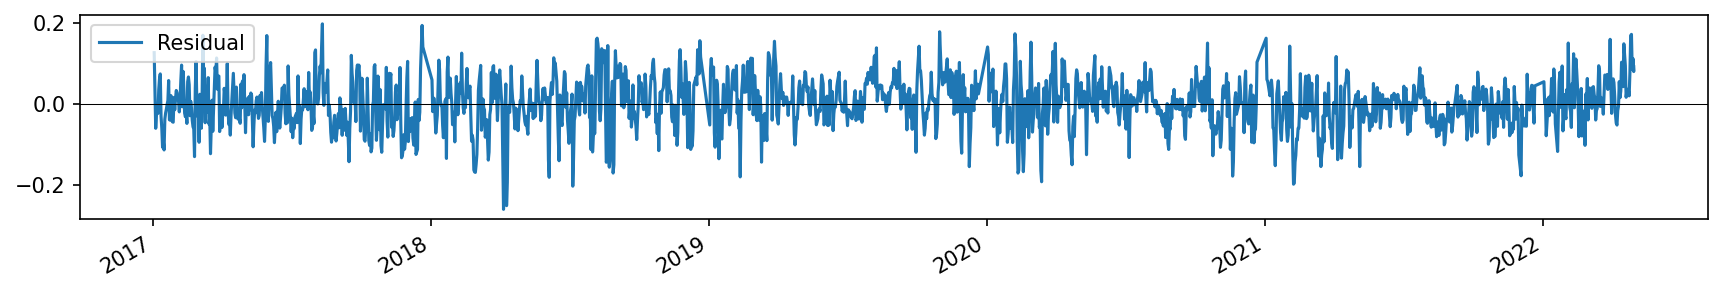

In [16]:
resid = results['industry']['temp+econ'].fittedvalues - dfx['industry'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['rlm']['temp+power+econ'].fittedvalues.plot(label='Fitted')
#dfx['rlm'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend(loc='upper left')

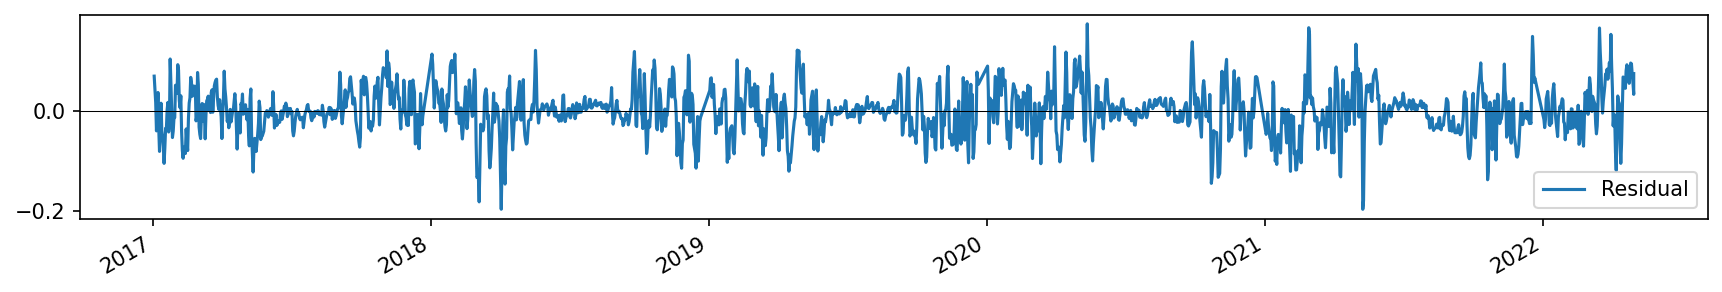

In [17]:
resid = results['slp']['temp+econ'].fittedvalues - dfx['slp'] 

plt.figure(figsize=(14, 2), dpi=150)
#results['slp']['temp+econ'].fittedvalues.plot(label='Fitted')
#dfx['slp'].plot(label='Observed')
resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

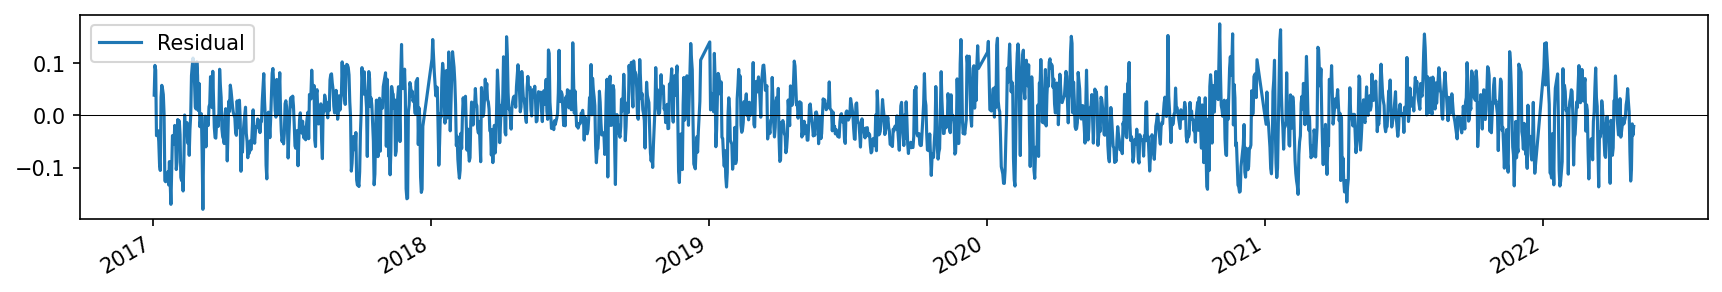

In [18]:
resid = results['power']['naive'].fittedvalues - dfx['power'] 

plt.figure(figsize=(14, 2), dpi=150)

resid.plot(label='Residual')
plt.axhline(0, color='black', linewidth=0.5)
plt.legend()

## Sensitivities

Crisis start: 1-2 month later crisis start does not change a lot, but including June-July significantly reduces average response of small & industial consumers

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

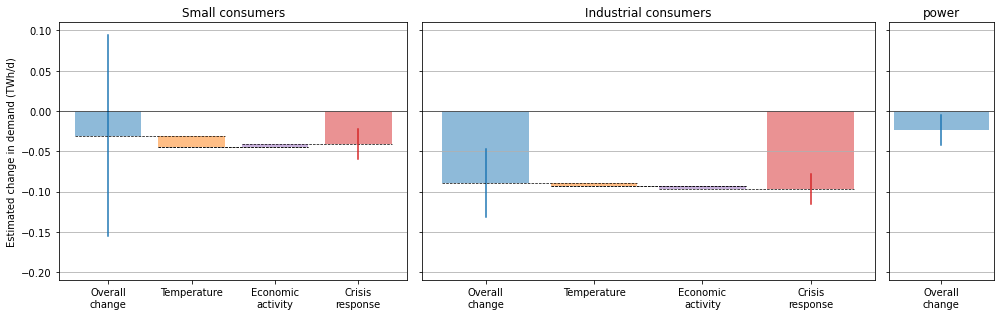

In [19]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-09-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

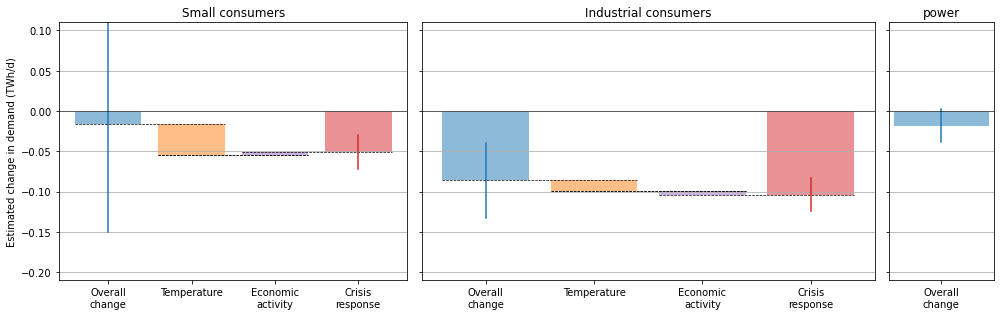

In [20]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-10-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

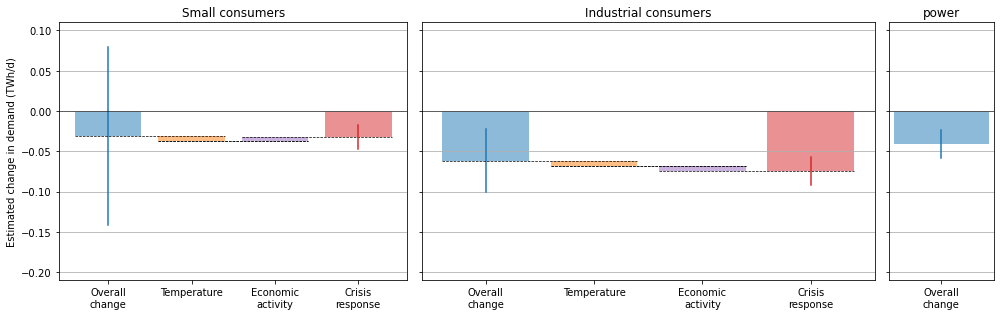

In [21]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-06-01" #default: 2021-08-01
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

Fitting period: Quite sensitive to change in fitting period, crisis response of industrial consumers increases with reduced fitting period while small consumers' response is rather stable

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

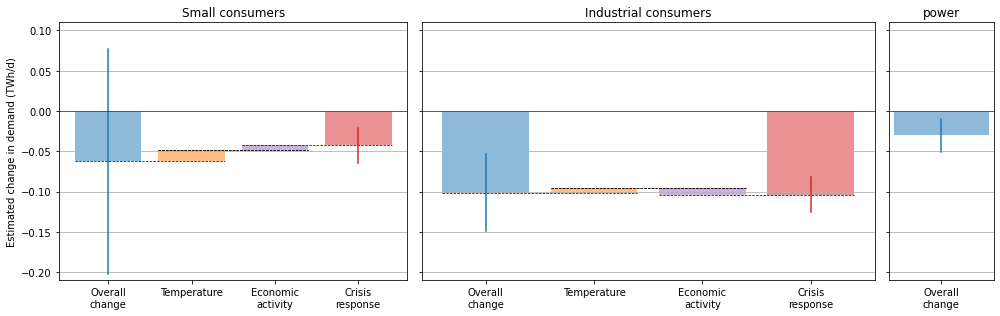

In [22]:
log=False
fitting_start = "2018-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.21, 0.11)

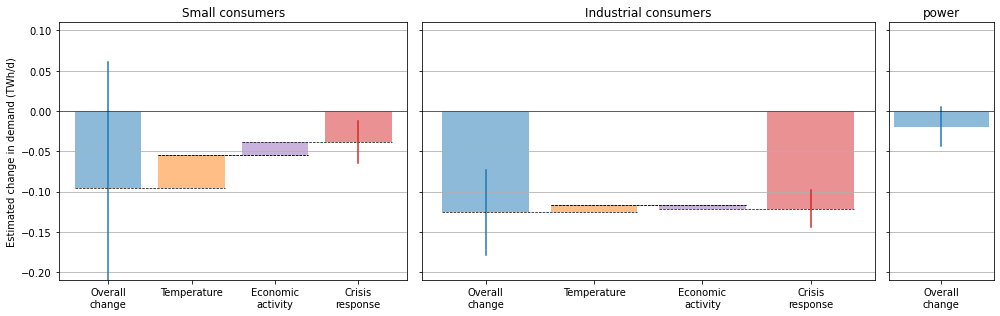

In [23]:
log=False
fitting_start = "2019-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.21, .11)

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar + manu + prod
power ~ 1 + time + C(month) + C(weekday) + crisis


(-0.25, 0.11)

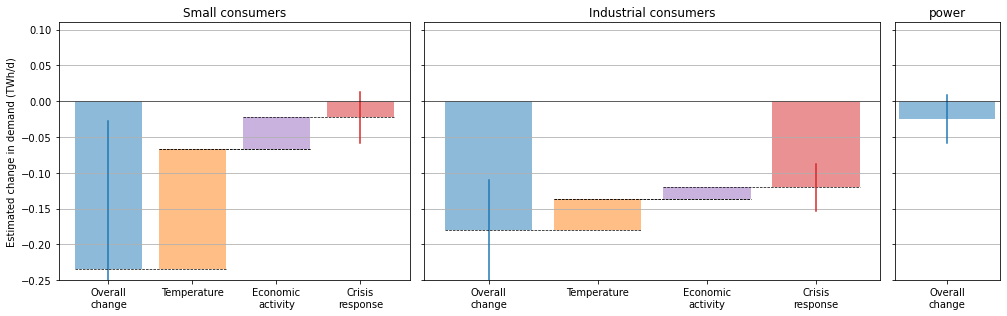

In [24]:
log=False
fitting_start = "2020-01-01" #default: 2017-01-01
crisis_start = "2021-09-01" 
results = one_dummy(econ=True)
plt.ylim(-.25, .11)

Add/remove control variables: Omitting economic activity does not change a lot

slp ~ 1 + time + C(month) + C(weekday) + crisis
slp ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
industry ~ 1 + time + C(month) + C(weekday) + crisis
industry ~ 1 + time + C(month) + C(weekday) + crisis + residential + commercial + time*residential + solar
power ~ 1 + time + C(month) + C(weekday) + crisis


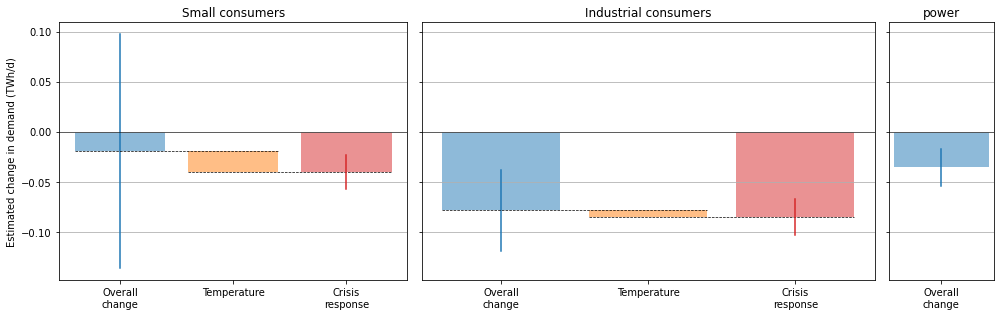

In [25]:
log=False
fitting_start = "2017-01-01"
crisis_start = "2021-08-01"
results = one_dummy(econ=False)

# Quarterly dummies (not currently used)

In [26]:
mode = 'quarterly'
crisis_start = "2021-09-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-04', freq='3m'):
    dummy_name = f'd{date.year}_{date.quarter}'
    dfx[dummy_name] = dfx.index.map( 
        lambda x: (x.year==date.year) & (x.quarter==date.quarter)
    ).values
    dummy_list.append(dummy_name)

# Monthly dummies

In [27]:
mode = 'monthly'
crisis_start = "2021-05-01"
dummy_list = []
for date in pd.date_range(crisis_start, '2022-05', freq='1m'):
    dummy_name = f'd{date.year}_{date.month}'
    dfx[dummy_name] = dfx.index.map(   
        lambda x: (x.year==date.year) & (x.month==date.month)
    ).values
    dummy_list.append(dummy_name)

In [28]:
def plot_monthly(ax, results, consumer='industry', ylabel='Crisis response (TWh/d)', names=None):

    colors = {
        'naive': 'tab:blue',
        'temp+econ': ('tab:orange' if consumer=='industry' else 'tab:red'),
        'power': 'tab:green'
    }
    extracted_results = {m: extract_results(dummy_list, value) for m, value in results[consumer].items()}
    
    if names==None:
        names = extracted_results.keys()
    
    for i, name in enumerate(names):
        
        res = extracted_results[name]
        
        idx = [j-0.15*(len(names)-1)+0.6/len(names)*i for j in range(len(res))]
        ax.bar(idx, res['coef'], width=0.6/len(names),alpha=0.5, label=name, color=colors[name])
        for j, d in enumerate(dummy_list):
            ax.plot([idx[j], idx[j]], [res.loc[d, 'low'], res.loc[d, 'high']], 
                     color=colors[name])
    ax.grid(axis='y')
    ax.axhline(0, color='black', linewidth=0.5)
    ax.set_ylabel(ylabel)
    ax.set_ylim(-0.2, 0.1)
    title_conversion = {
        'slp':'Small consumers',
        'rlm':'Large consumers',
        'industry':'Industrial consumers',
        'power': "power"
    }
    ax.set_title(title_conversion[consumer])
   
    ax.set_xticks(
        range(len(res)), 
    #    [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
    #     for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    ax.set_xticklabels(
        [f'{date.month_name()[:3]}'+(f'\n{date.year}' if ((date.month==1) | (i==0)) else '')
         for i, date in enumerate(pd.date_range(crisis_start, '2022-05', freq='1m'))]
    )
    
    ax.axvline(7.5, color='black', linewidth=0.5)

In [29]:
log=False
results = {consumer: all_models(dummy_list, consumer, econ=True) for consumer in ['slp', 'industry', 'power']}

slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
slp ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar + hosp + retail
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4
industry ~ 1 + time + C(month) + C(weekday) + d2021_5 + d2021_6 + d2021_7 + d2021_8 + d2021_9 + d2021_10 + d2021_11 + d2021_12 + d2022_1 + d2022_2 + d2022_3 + d2022_4 + residential + commercial + time*residential + solar
in

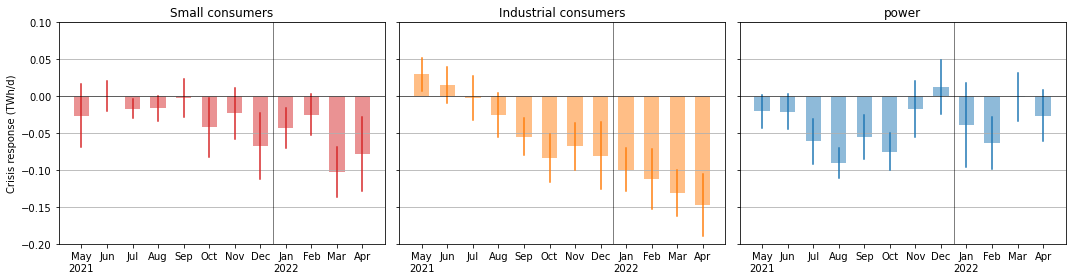

In [30]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,4), sharey='row', gridspec_kw={'width_ratios': [1,1,1]})

plot_monthly(ax1, results, 'slp', names=['temp+econ'])
#ax1.text(10.5, 0.02, 'Invasion\nof Ukraine', horizontalalignment='center')

plot_monthly(ax2, results, names=['temp+econ'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plot_monthly(ax3, results, "power", names=['naive'], ylabel='')
#ax2.text(4.5, 0.02, 'TTF prices\nall-time-high', horizontalalignment='center')

plt.tight_layout()
plt.savefig('months.png')

In [31]:
#results['industry']['temp+econ'].summary()
results['power']['naive'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  power   R-squared:                       0.504
Model:                            OLS   Adj. R-squared:                  0.495
Method:                 Least Squares   F-statistic:                     64.62
Date:                Fri, 15 Jul 2022   Prob (F-statistic):          5.36e-258
Time:                        13:53:21   Log-Likelihood:                 2573.1
No. Observations:                1788   AIC:                            -5084.
Df Residuals:                    1757   BIC:                            -4914.
Df Model:                          30                                         
Covariance Type:                  HAC                                         
===========================================================================================
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                   0.2702      0.014     19.742      0.000       0.243       0.297
C(month)[T.2]              -0.0156      0.015     -1.027      0.304      -0.045       0.014
C(month)[T.3]              -0.0536      0.014     -3.736      0.000      -0.082      -0.025
C(month)[T.4]              -0.0828      0.015     -5.513      0.000      -0.112      -0.053
C(month)[T.5]              -0.1028      0.013     -7.806      0.000      -0.129      -0.077
C(month)[T.6]              -0.0943      0.014     -6.940      0.000      -0.121      -0.068
C(month)[T.7]              -0.0769      0.013     -5.801      0.000      -0.103      -0.051
C(month)[T.8]              -0.0848      0.013     -6.319      0.000      -0.111      -0.058
C(month)[T.9]              -0.0806      0.015     -5.233      0.000      -0.111      -0.050
C(month)[T.10]             -0.0620      0.014     -4.322      0.000      -0.090      -0.034
C(month)[T.11]             -0.0156      0.015     -1.029      0.303      -0.045       0.014
C(month)[T.12]             -0.0057      0.018     -0.317      0.751      -0.041       0.030
C(weekday)[T.Monday]       -0.0009      0.005     -0.203      0.839      -0.010       0.008
C(weekday)[T.Saturday]     -0.0677      0.003    -19.739      0.000      -0.074      -0.061
C(weekday)[T.Sunday]       -0.0918      0.004    -22.657      0.000      -0.100      -0.084
C(weekday)[T.Thursday]      0.0126      0.004      3.421      0.001       0.005       0.020
C(weekday)[T.Tuesday]       0.0149      0.005      3.069      0.002       0.005       0.024
C(weekday)[T.Wednesday]     0.0111      0.005      2.394      0.017       0.002       0.020
d2021_5[T.True]            -0.0203      0.011     -1.830      0.067      -0.042       0.001
d2021_6[T.True]            -0.0206      0.012     -1.700      0.089      -0.044       0.003
d2021_7[T.True]            -0.0605      0.015     -3.978      0.000      -0.090      -0.031
d2021_8[T.True]            -0.0899      0.010     -8.980      0.000      -0.109      -0.070
d2021_9[T.True]            -0.0550      0.015     -3.759      0.000      -0.084      -0.026
d2021_10[T.True]           -0.0750      0.013     -5.980      0.000      -0.100      -0.050
d2021_11[T.True]           -0.0173      0.019     -0.908      0.364      -0.055       0.020
d2021_12[T.True]            0.0130      0.018      0.712      0.476      -0.023       0.049
d2022_1[T.True]            -0.0386      0.028     -1.360      0.174      -0.094       0.017
d2022_2[T.True]            -0.0631      0.018     -3.603      0.000      -0.097      -0.029
d2022_3[T.True]            -0.0009      0.016     -0.053      0.958      -0.033       0.031
d2022_4[T.True]            -0.0259      0.017     -1.517      0.129      -0.059       0.008
time                     2.671e-05   6.64e-06  